### Load in needed library and helper funcs:

In [1]:
import sys
import os
import gc
import numpy as np
import pandas as pd 
import tensorflow
import tensorflow.compat.v2 as tf
import warnings
warnings.filterwarnings("ignore")
## silence tensorflow warning messages
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/creditCardFraud/SupervisedLearning/scripts/")

In [3]:
from util import *
from NN_util import *
%load_ext autoreload
%autoreload 2

In [4]:
# make sure GPU is running 
tf.test.gpu_device_name()
set_gpu_limit(7.5)

----
### Load in Data and split into train and test
* feature scale among columns are relatively close so it won't affect gradient descent as much

In [5]:
train = pd.read_csv("../../AnomalyDetection/processedData/TrainingData_normal.csv")
dev = pd.read_csv("../../AnomalyDetection/processedData/DevData_normal.csv")
test = pd.read_csv("../../AnomalyDetection/processedData/hold_outset_moreFraud.csv")

In [6]:
training,testing = train_test_dfs(train,dev,test,"Class",0.1,2020)
test_X, test_y = testing.drop("Class",axis=1).values, testing.Class.values;

### Garbage Collect

In [7]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


---
### Set NN constants

In [8]:
batch_size = 256
epochs = 100
sizes = [256,256] 
input_size = train.shape[1]

### Set Custom Metrics:
* TruePostivies
* FalsePostives
* FalseNegatives
* PR AUC (precision recall curve, better for imbalanced dataset) 
* Minority Class Precision
* Minority Class Recall 


In [9]:
METRICS = [
    tfk.metrics.TruePositives(name='tp'),
    tfk.metrics.FalsePositives(name='fp'),
    tfk.metrics.FalseNegatives(name='fn'),
    tfk.metrics.AUC(curve = "PR", name = "AUC_PR"),
    tfk.metrics.Precision(class_id = 0, name = "Precsion"),
    tfk.metrics.Recall(class_id = 0, name = "Recall")
]

### Convert to tensorflow dataset using traing set only

In [10]:
train_set, dev_set = make_tensor_dataset(training,"Class",batch_size,0.2,10090)

### Define earlystop and create model
  * optimize on val_auc_pr

In [11]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_AUC_PR",mode="max",
                                        patience=5,verbose=1,restore_best_weights=True)

In [12]:
classifier = make_model(sizes,input_size,METRICS,l1=1e-5,lr=1e-4)

In [13]:
classifier.summary()

Model: "NN_binary_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256)               73728     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 73,985
Trainable params: 73,985
Non-trainable params: 0
_________________________________________________________________


----
### Tune model 

In [14]:
history = classifier.fit(train_set, epochs=epochs,shuffle=True,
                         verbose = 1, validation_data=dev_set,
                         callbacks=[earlystop])

Epoch 1/100
802/802 [==============================] - 4s 5ms/step - loss: 0.0159 - tp: 157.0000 - fp: 46.0000 - fn: 207.0000 - AUC_PR: 0.4063 - Precsion: 0.7734 - Recall: 0.4313 - val_loss: 0.0083 - val_tp: 62.0000 - val_fp: 7.0000 - val_fn: 26.0000 - val_AUC_PR: 0.6795 - val_Precsion: 0.8986 - val_Recall: 0.7045
Epoch 2/100
802/802 [==============================] - 3s 4ms/step - loss: 0.0070 - tp: 252.0000 - fp: 35.0000 - fn: 112.0000 - AUC_PR: 0.7493 - Precsion: 0.8780 - Recall: 0.6923 - val_loss: 0.0069 - val_tp: 67.0000 - val_fp: 10.0000 - val_fn: 21.0000 - val_AUC_PR: 0.7764 - val_Precsion: 0.8701 - val_Recall: 0.7614
Epoch 3/100
802/802 [==============================] - 3s 4ms/step - loss: 0.0060 - tp: 267.0000 - fp: 36.0000 - fn: 97.0000 - AUC_PR: 0.8000 - Precsion: 0.8812 - Recall: 0.7335 - val_loss: 0.0063 - val_tp: 67.0000 - val_fp: 9.0000 - val_fn: 21.0000 - val_AUC_PR: 0.8041 - val_Precsion: 0.8816 - val_Recall: 0.7614
Epoch 4/100
802/802 [==============================]

Epoch 27/100
802/802 [==============================] - 3s 4ms/step - loss: 0.0025 - tp: 310.0000 - fp: 10.0000 - fn: 54.0000 - AUC_PR: 0.9237 - Precsion: 0.9688 - Recall: 0.8516 - val_loss: 0.0041 - val_tp: 68.0000 - val_fp: 12.0000 - val_fn: 20.0000 - val_AUC_PR: 0.8376 - val_Precsion: 0.8500 - val_Recall: 0.7727
Epoch 28/100
802/802 [==============================] - 3s 4ms/step - loss: 0.0024 - tp: 312.0000 - fp: 8.0000 - fn: 52.0000 - AUC_PR: 0.9257 - Precsion: 0.9750 - Recall: 0.8571 - val_loss: 0.0043 - val_tp: 65.0000 - val_fp: 6.0000 - val_fn: 23.0000 - val_AUC_PR: 0.8178 - val_Precsion: 0.9155 - val_Recall: 0.7386
Epoch 29/100
802/802 [==============================] - 3s 4ms/step - loss: 0.0024 - tp: 311.0000 - fp: 8.0000 - fn: 53.0000 - AUC_PR: 0.9301 - Precsion: 0.9749 - Recall: 0.8544 - val_loss: 0.0042 - val_tp: 66.0000 - val_fp: 7.0000 - val_fn: 22.0000 - val_AUC_PR: 0.8312 - val_Precsion: 0.9041 - val_Recall: 0.7500
Epoch 30/100
802/802 [==============================]

### Garbage Collect:

In [15]:
gc.collect()
%reset -f out 

Flushing output cache (0 entries)


### Check out results

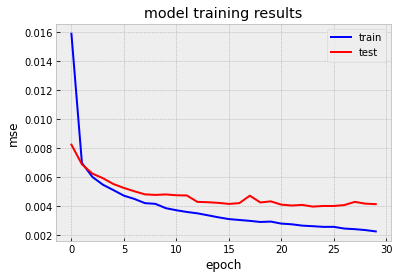

In [16]:
plot_loss(history)

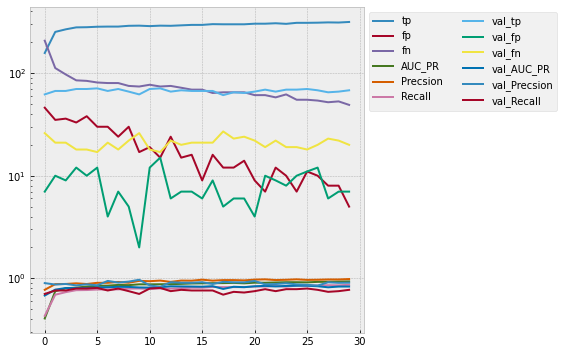

In [17]:
plot_metrics(history)

### Garbage collect

In [18]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


----
### Check for testing results

In [19]:
test_pred_score = classifier.predict_proba(test_X,batch_size=batch_size).ravel()

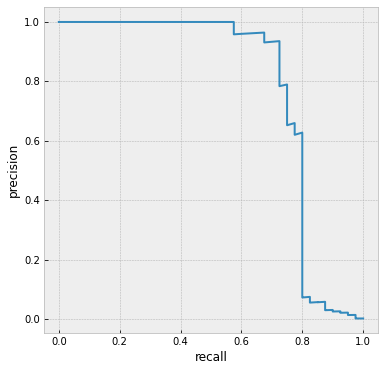

In [20]:
plot_pr_re(test_y,test_pred_score)

### With a threshold of 0.5

In [27]:
output = model_results(test_y,test_pred_score,threshold=0.5,ifprint=True)

[[28439     2]
 [   11    29]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28441
           1       0.94      0.72      0.82        40

    accuracy                           1.00     28481
   macro avg       0.97      0.86      0.91     28481
weighted avg       1.00      1.00      1.00     28481



### This is just a simple demonstration of a simple NN with l1 regularization produces reasonable outcome 
----